# In this code i wanna merge the Direct and Indirect Delivery and Plot it 

In [2]:
# Standard libraries
import os
import glob
import warnings
import gc

# Data manipulation and analysis libraries
import numpy as np
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point
from netCDF4 import Dataset
# geopandas 
from shapely.geometry import Point
import geopandas as gpd

# Dask diagnostics and progress bar
from dask.diagnostics import ProgressBar

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import cartopy.crs as ccrs
from pylag.processing.plot import FVCOMPlotter, create_figure, colourmap

In [15]:
# Inputs
InDirect_dir = '/home/abolmaal/modelling/FVCOM/Huron/InDirectNP_load'
Direct_dir = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/ZonalStats'


categories = ['avg', 'high', 'low', 'surge']
year = 23
# outputs
out_dir_fig = '/home/abolmaal/modelling/FVCOM/Huron/figures'
out_dir = '/home/abolmaal/modelling/FVCOM/Huron/TotalNP'

In [4]:
import os
import pandas as pd

def merge_direct_indirect_loads(category, direct_dir, indirect_dir, out_dir, year="23"):
    direct_file = os.path.join(direct_dir, f'DirectTNTP_CoastalWatershed_{category}.csv')
    indirect_file = os.path.join(indirect_dir, f'Indirect_CW_{category}_{year}.csv')

    if not os.path.exists(indirect_file):
        raise FileNotFoundError(f"❌ Indirect file not found: {indirect_file}")
    if not os.path.exists(direct_file):
        raise FileNotFoundError(f"❌ Direct file not found: {direct_file}")

    direct_df = pd.read_csv(direct_file)
    indirect_df = pd.read_csv(indirect_file)

    # Rename CW_Area to avoid conflicts
    direct_df.rename(columns={'CW_Area': 'CW_Area_direct'}, inplace=True)
    indirect_df.rename(columns={'CW_Area': 'CW_Area_indirect'}, inplace=True)

    # Merge on CW_Id
    merged_df = pd.merge(
        direct_df,
        indirect_df,
        on='CW_Id',
        how='left',
        suffixes=('_direct', '_indirect')
    ).fillna(0)

    # Total nutrient loads
    merged_df[f'TotalN_{category}_grm2yr'] = (
        merged_df['TotalIndirectCW_TN_grm2yr'] +
        merged_df[f'CoastalWatershedDirectTN_{category}_grm2yr']
    )
    merged_df[f'TotalP_{category}_grm2yr'] = (
        merged_df['TotalIndirectCW_TP_grm2yr'] +
        merged_df[f'CoastalWatershedDirectTP_{category}_grm2yr']
    )

    # Select and reorder columns
    selected_columns = [
        'CW_Id',
        'start_lat',
        'start_lon',
        f'CoastalWatershedDirectTN_{category}_grm2yr',
        f'CoastalWatershedDirectTP_{category}_grm2yr',
        'TotalIndirectCW_TN_grm2yr',
        'TotalIndirectCW_TP_grm2yr',
        f'TotalN_{category}_grm2yr',
        f'TotalP_{category}_grm2yr',
        'Wetland',
        'group_ids',
        'particle_ids',
    ]
    merged_df = merged_df[selected_columns]

    # Save to CSV
    output_file = os.path.join(out_dir, f'Total_Direct_Indirect_Loads_{category}_{year}.csv')
    merged_df.to_csv(output_file, index=False)

    return merged_df


In [5]:
# estimate the total N & P for each coastal wetland by merging the direct and indirect loads and summing them
merged_results = {}

for cat in categories:
    merged_results[cat] = merge_direct_indirect_loads(cat, Direct_dir, InDirect_dir, out_dir)

In [7]:
# show the results for avg category
merged_results['avg'].head()

,CW_Id,start_lat,start_lon,CoastalWatershedDirectTN_avg_grm2yr,CoastalWatershedDirectTP_avg_grm2yr,TotalIndirectCW_TN_grm2yr,TotalIndirectCW_TP_grm2yr,TotalN_avg_grm2yr,TotalP_avg_grm2yr,Wetland,group_ids,particle_ids
0,1,45.564909,-84.130356,14.685401,0.337714,95.312667,3.268332,109.998068,3.606045,Emergent Wetland,"[16, 0, 3]","[522305, 16582307, 652301, 3462303]"
1,2,45.556107,-84.125917,1.737483,0.039956,158.424511,5.732219,160.161994,5.772175,Emergent Wetland,"[16, 0, 3, 15]","[3682304, 3442308, 15442308, 15522308, 1616230..."
2,3,45.553651,-84.126473,2.593307,0.078607,127.392220,8.334712,129.985527,8.413319,Emergent Wetland,[3],"[3552303, 3392303, 3312304, 3082303]"
3,4,45.550923,-84.126687,0.184454,0.005874,725.372070,27.427333,725.556524,27.433207,Emergent Wetland,"[16, 0, 3, 15]","[3362304, 15202306, 15202308, 3212303, 3212304..."
4,5,45.535541,-84.125815,67.001184,1.540797,701.100300,25.909376,768.101484,27.450173,Emergent Wetland,"[16, 3, 15]","[3522307, 3062307, 15062308, 15242308, 1527230..."


In [6]:
# print min and max values for TotalN_avg_grm2yr and TotalP_avg_grm2yr
print("TotalN_avg_grm2yr - Min:", merged_results['avg']['TotalN_avg_grm2yr'].min(), 
      "Max:", merged_results['avg']['TotalN_avg_grm2yr'].max())
print("TotalP_avg_grm2yr - Min:", merged_results['avg']['TotalP_avg_grm2yr'].min(), 
      "Max:", merged_results['avg']['TotalP_avg_grm2yr'].max())


TotalN_avg_grm2yr - Min: 0.0112873159989814 Max: 1012221.8816864918
TotalP_avg_grm2yr - Min: 0.0001739402964047 Max: 34341.693983656536


In [10]:
# show the results for high category
merged_results['high'].describe()

,CW_Id,CoastalWatershedDirectTN_high_grm2yr,CoastalWatershedDirectTP_high_grm2yr,TotalIndirectCW_TN_grm2yr,TotalIndirectCW_TP_grm2yr,TotalN_high_grm2yr,TotalP_high_grm2yr
count,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000
mean,3150.681274,3.247964,3.247964,112.271509,3.448959,115.519473,6.696923
std,1824.394128,140.774724,140.774724,553.316514,17.678041,571.122433,141.911882
min,1.000000,0.000005,0.000005,0.000000,0.000000,0.000014,0.000014
25%,1555.750000,0.010605,0.010605,0.000000,0.000000,0.031816,0.029368
50%,3163.500000,0.047723,0.047723,0.000000,0.000000,0.127251,0.127251
75%,4730.250000,0.190876,0.190876,0.006879,0.000872,2.564526,0.381753
max,6330.000000,10838.476777,10838.476777,9449.642326,309.729155,10838.476777,10838.476777


# Read the results 

In [8]:
# read all the category of the merged results
# Loop and read each file into its own named variable like Total_avg_23, Total_high_23, etc.
for cat in categories:
    file_path = os.path.join(out_dir, f'Total_Direct_Indirect_Loads_{cat}_{year}.csv')
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['Category'] = cat  # Optional: tag the category inside the DataFrame
        var_name = f"Total_{cat}_{year}"
        globals()[var_name] = df  # Creates variable like Total_avg_23
        print(f"✅ Loaded: {var_name}")
    else:
        print(f"❌ File not found: {file_path}")


✅ Loaded: Total_avg_23
✅ Loaded: Total_high_23
✅ Loaded: Total_low_23
✅ Loaded: Total_surge_23


In [9]:
# print the unique values in Wetland column 
print(Total_avg_23['Wetland'].unique())

# couunt the occurance of each unique value in Wetland column
wetland_counts = Total_avg_23['Wetland'].value_counts()
print(wetland_counts)


['Emergent Wetland' '0' 'Typha' 'Forested Wetland' 'Shrub Peatland'
 'Shrub Wetland' 'Phragmites' 'Schoenoplectus' 'Aquatic Bed']
Wetland
0                   2857
Phragmites           728
Emergent Wetland     293
Typha                166
Aquatic Bed          109
Shrub Wetland         73
Forested Wetland      13
Schoenoplectus         9
Shrub Peatland         1
Name: count, dtype: int64


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_log_boxplot_grouped(df, nutrient_col, wetland_col, output_dir=".", title=None):
    d = df[[nutrient_col, wetland_col]].copy()

    # Keep only positive values
    d = d[np.isfinite(d[nutrient_col]) & (d[nutrient_col] > 0)]

    # Group wetland types -> one combined category
    group_map = {
        'Shrub Peatland': 'Shrub/Forested',
        'Shrub Wetland': 'Shrub/Forested',
        'Forested Wetland': 'Shrub/Forested',
    }
    d['wetland_group'] = d[wetland_col].replace(group_map)

    # Drop invalid labels
    d = d[(d['wetland_group'].notna()) &
          (d['wetland_group'] != 0) &
          (d['wetland_group'] != '0')]

    # Log10 transform
    d['log_val'] = np.log10(d[nutrient_col])

    # Order categories by frequency
    order = d['wetland_group'].value_counts().index.tolist()

    # Create plot
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(data=d, x='wetland_group', y='log_val', order=order, showfliers=False)

    # Set title
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f'Boxplot of log₁₀({nutrient_col}) by {wetland_col} (Grouped)')

    ax.set_xlabel(wetland_col)
    ax.set_ylabel(f'log₁₀({nutrient_col})')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save figure
    safe_title = title.replace(" ", "_") if title else nutrient_col
    filename = f"boxplot_{safe_title}.png"
    filepath = os.path.join(out_dir_fig, filename)
    os.makedirs(out_dir_fig, exist_ok=True)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {filepath}")

    #plt.show()


✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/figures/boxplot_TotalN_avg_grm2yr_by_Wetland_Group.png


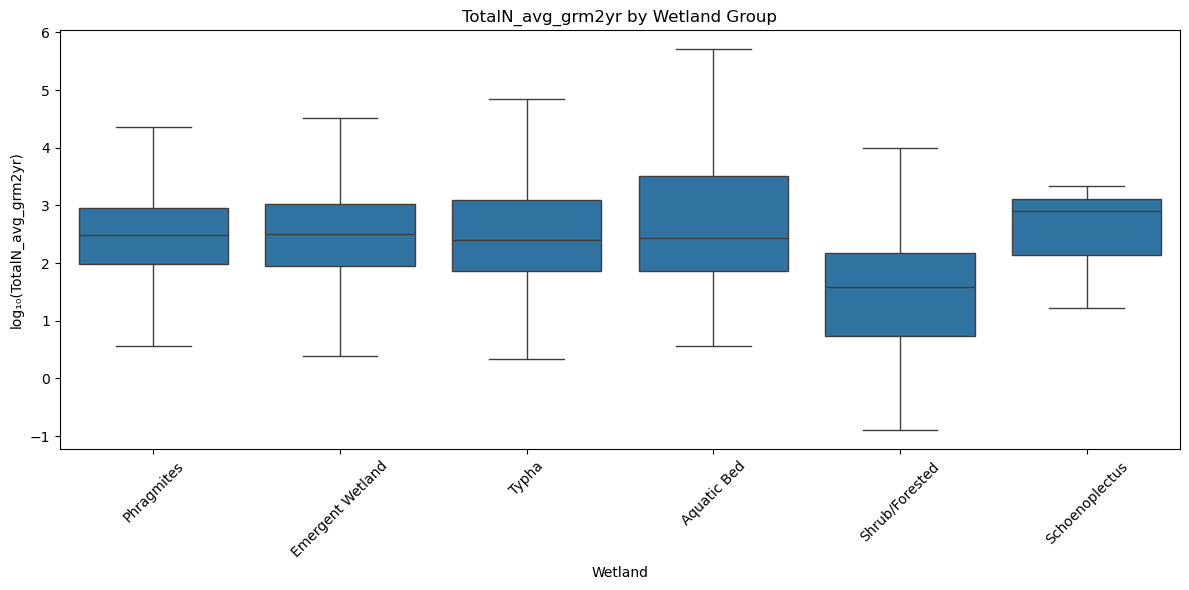

✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/figures/boxplot_TotalP_avg_grm2yr_by_Wetland_Group.png


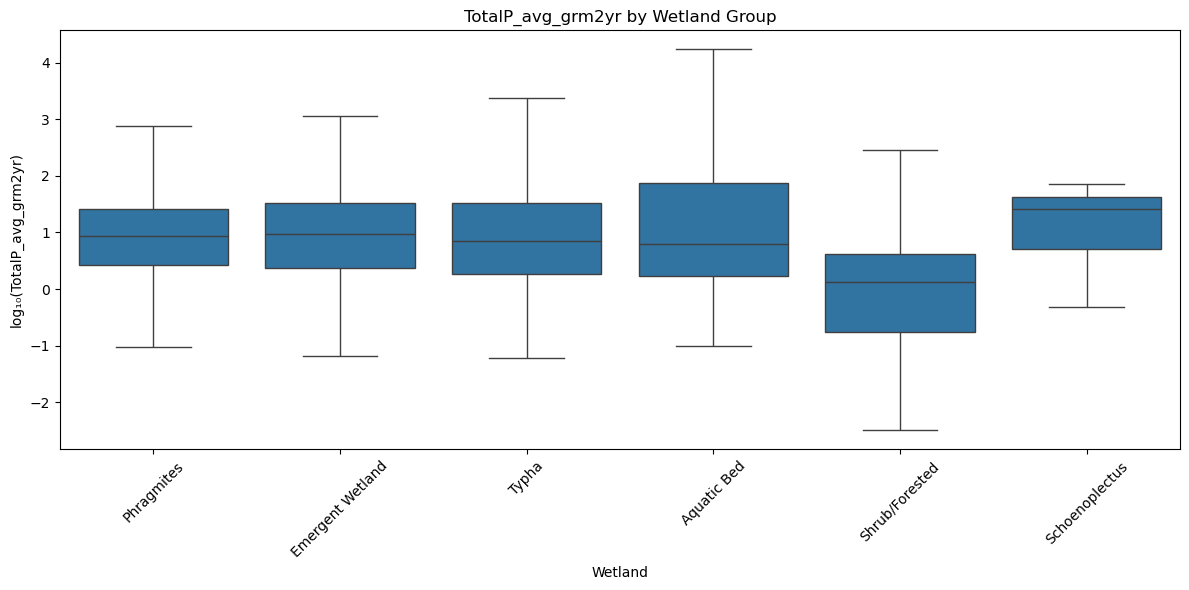

In [28]:
# examples
plot_log_boxplot_grouped(Total_avg_23, 'TotalN_avg_grm2yr', 'Wetland',output_dir = out_dir_fig, title='TotalN_avg_grm2yr by Wetland Group')
plot_log_boxplot_grouped(Total_avg_23, 'TotalP_avg_grm2yr', 'Wetland',output_dir = out_dir_fig, title='TotalP_avg_grm2yr by Wetland Group')



✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/figures/boxplot_TotalN_high_grm2yr_by_Wetland_Group.png
✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/figures/boxplot_TotalP_high_grm2yr_by_Wetland_Group.png
✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/figures/boxplot_TotalN_low_grm2yr_by_Wetland_Group.png
✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/figures/boxplot_TotalP_low_grm2yr_by_Wetland_Group.png
✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/figures/boxplot_TotalN_surge_grm2yr_by_Wetland_Group.png
✅ Saved: /home/abolmaal/modelling/FVCOM/Huron/figures/boxplot_TotalP_surge_grm2yr_by_Wetland_Group.png


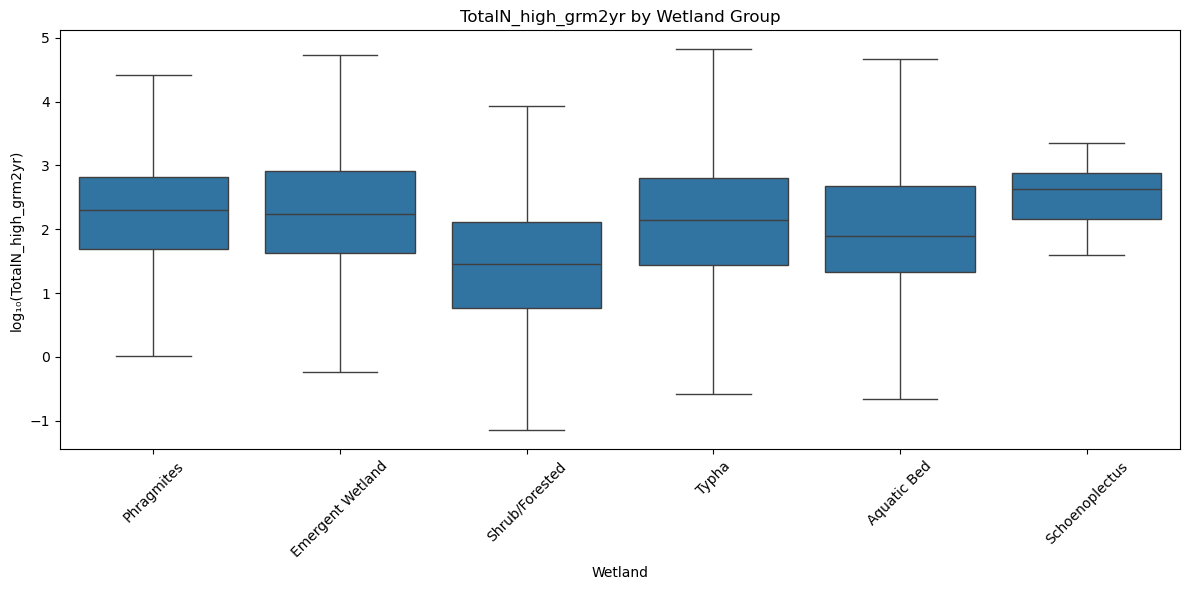

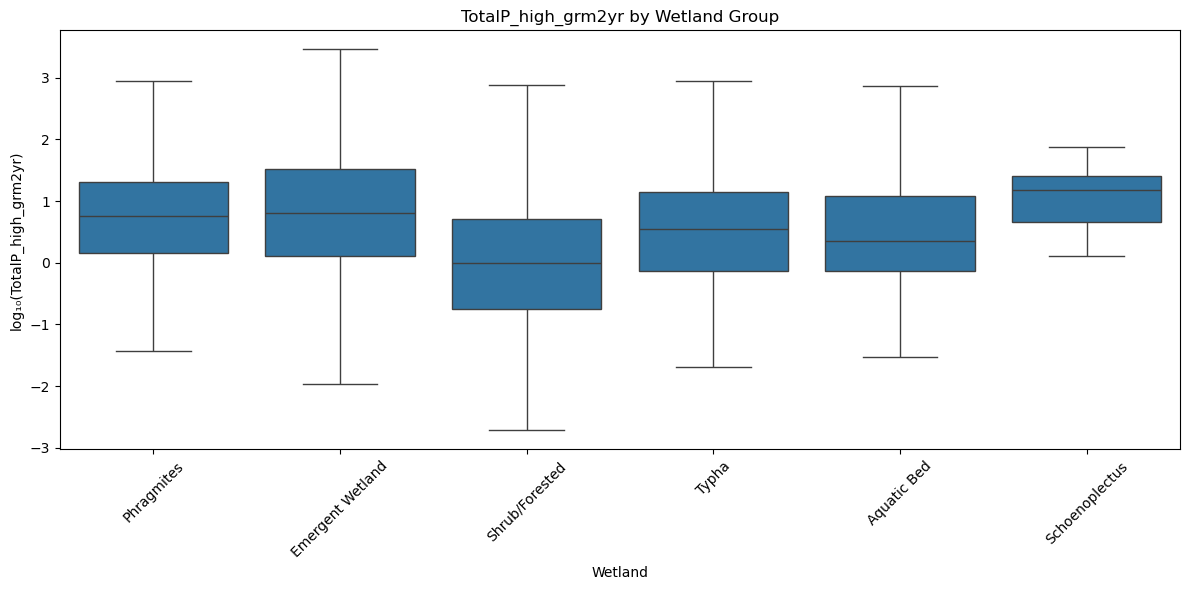

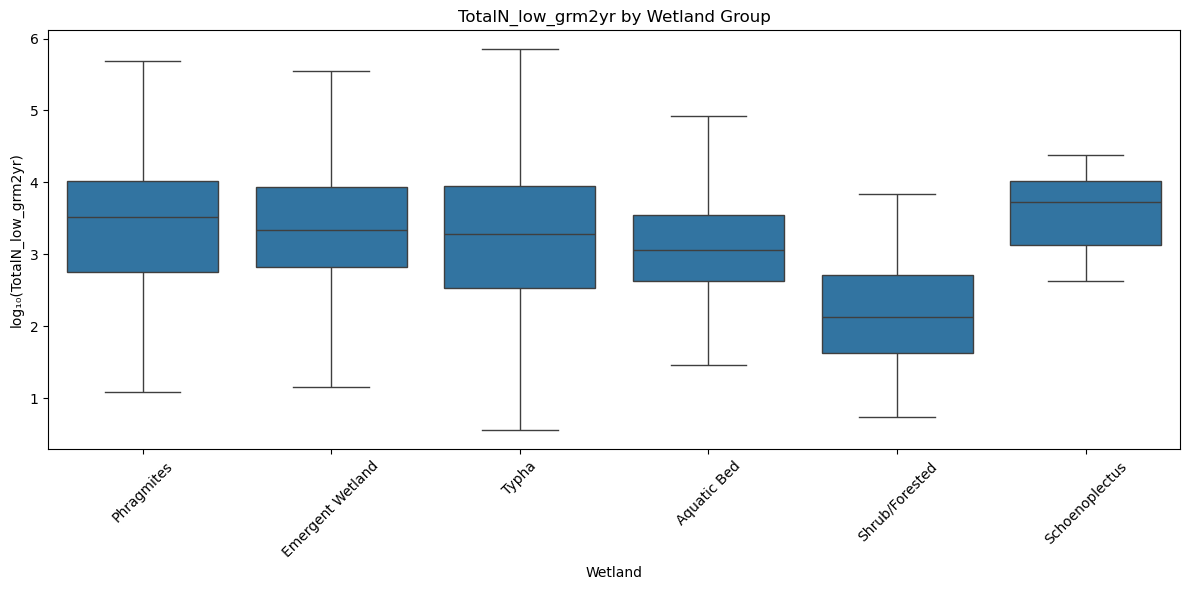

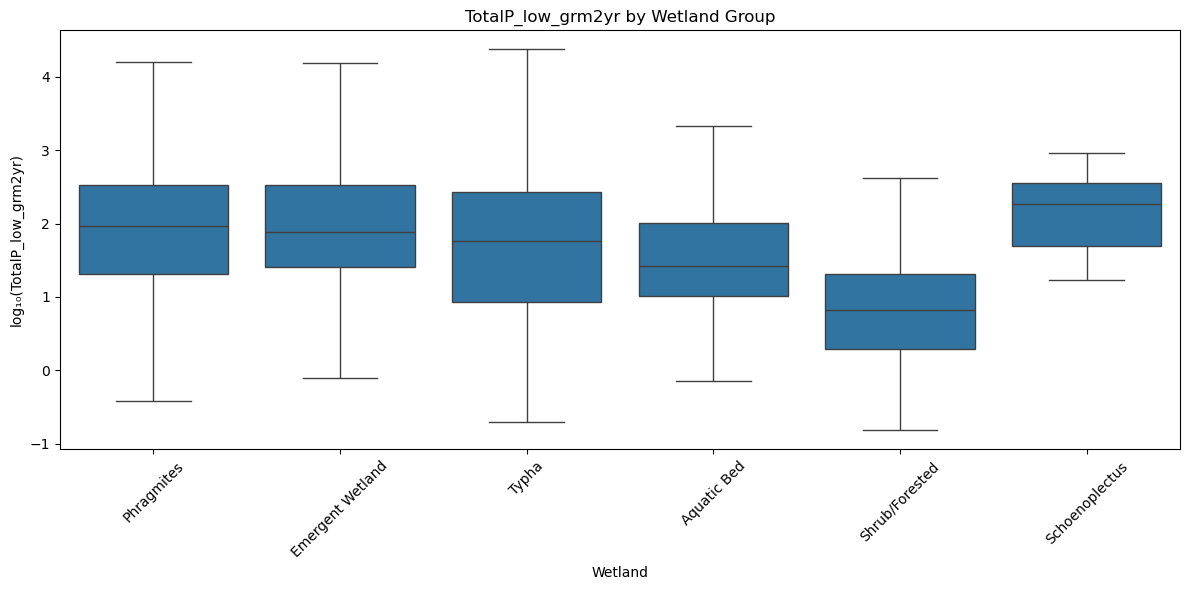

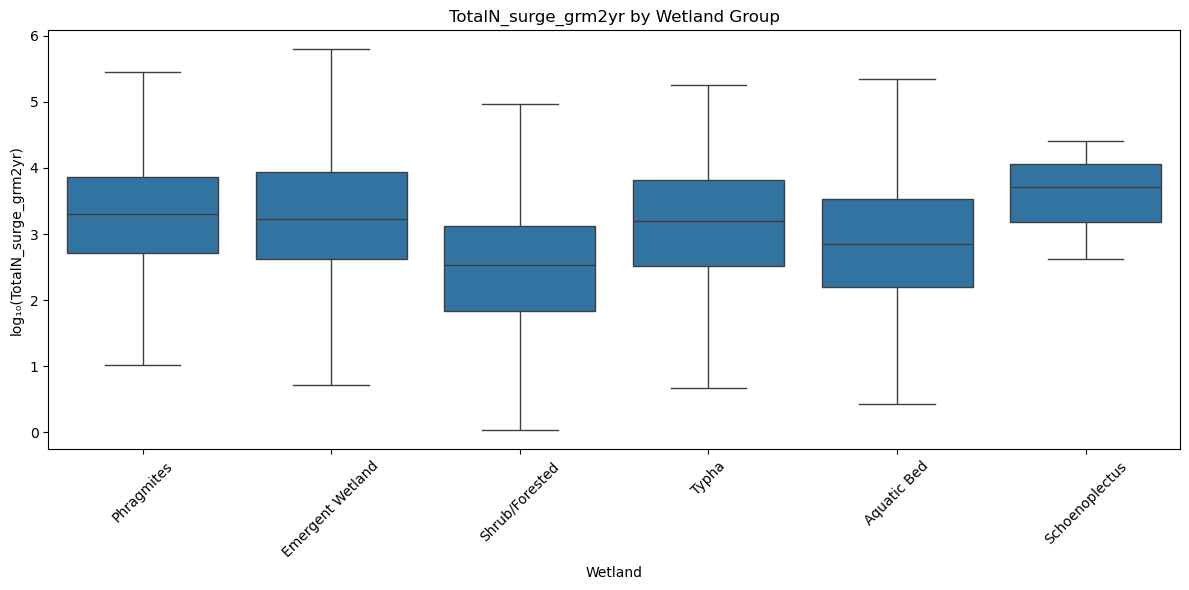

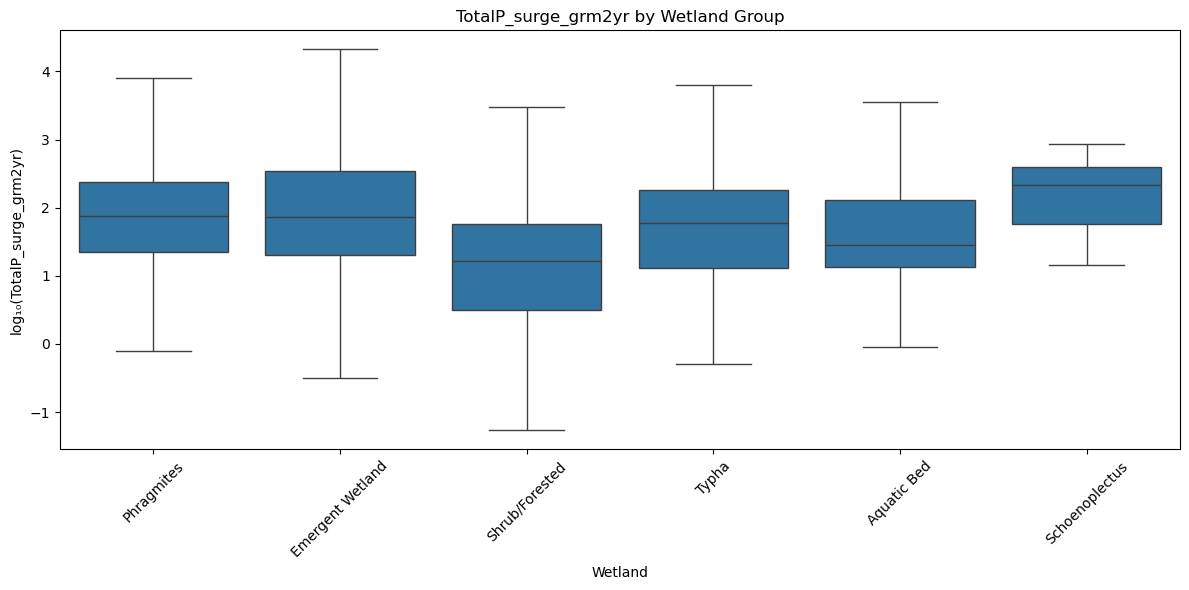

In [30]:
# examples
plot_log_boxplot_grouped(Total_high_23, 'TotalN_high_grm2yr', 'Wetland',output_dir = out_dir_fig, title='TotalN_high_grm2yr by Wetland Group')
plot_log_boxplot_grouped(Total_high_23, 'TotalP_high_grm2yr', 'Wetland',output_dir = out_dir_fig, title='TotalP_high_grm2yr by Wetland Group')

# examples
plot_log_boxplot_grouped(Total_low_23, 'TotalN_low_grm2yr', 'Wetland',output_dir = out_dir_fig, title='TotalN_low_grm2yr by Wetland Group')
plot_log_boxplot_grouped(Total_low_23, 'TotalP_low_grm2yr', 'Wetland',output_dir = out_dir_fig, title='TotalP_low_grm2yr by Wetland Group')

# examples
plot_log_boxplot_grouped(Total_surge_23, 'TotalN_surge_grm2yr', 'Wetland',output_dir = out_dir_fig, title='TotalN_surge_grm2yr by Wetland Group')
plot_log_boxplot_grouped(Total_surge_23, 'TotalP_surge_grm2yr', 'Wetland',output_dir = out_dir_fig, title='TotalP_surge_grm2yr by Wetland Group')



In [11]:
# couunt the occurance of each unique value in Wetland column
wetland_counts = Total_high_23['Wetland'].value_counts()
print(wetland_counts)

Wetland
0                   4635
Phragmites           615
Emergent Wetland     373
Typha                206
Shrub Wetland        178
Aquatic Bed          117
Forested Wetland      52
Schoenoplectus         8
Name: count, dtype: int64


In [ ]:
# show median max and min of Annual_N and Annual_P
print("Median Total_N:", Total_low_23['TotalN_low_grm2yr'].median())
print("Max Total_N:", Total_low_23['TotalN_low_grm2yr'].max())
print("Min Total_N:", Total_low_23['TotalN_low_grm2yr'].min())
print("median Total_P:", Total_low_23['TotalP_low_grm2yr'].median())
print("Max Total_P:", Total_low_23['TotalP_low_grm2yr'].max())
print("Min Total_P:", Total_low_23['TotalP_low_grm2yr'].min())

Median Total_N: 0.8221613250023068
Max Total_N: 550824.586067694
Min Total_N: 0.0002145955203289
median Total_P: 0.8221613250023068
Max Total_P: 206078.4169678857
Min Total_P: 0.0002145955203289


In [21]:
# print the median, max and min of IndirectCW_TN_grm2yr and IndirectCW_TP_grm2yr
print("Median IndirectCW_TN_grm2yr:", Total_low_23['TotalIndirectCW_TN_grm2yr'].mean())
print("Max IndirectCW_TN_grm2yr:", Total_low_23['TotalIndirectCW_TN_grm2yr'].max())
print("Min IndirectCW_TN_grm2yr:", Total_low_23['TotalIndirectCW_TN_grm2yr'].min())
print("Median IndirectCW_TP_grm2yr:", Total_low_23['TotalIndirectCW_TP_grm2yr'].mean())
print("Max IndirectCW_TP_grm2yr:", Total_low_23['TotalIndirectCW_TP_grm2yr'].max())
print("Min IndirectCW_TP_grm2yr:", Total_low_23['TotalIndirectCW_TP_grm2yr'].min())


Median IndirectCW_TN_grm2yr: 1414.657913272884
Max IndirectCW_TN_grm2yr: 550822.528029249
Min IndirectCW_TN_grm2yr: 0.0
Median IndirectCW_TP_grm2yr: 45.79150848762854
Max IndirectCW_TP_grm2yr: 18686.67991128175
Min IndirectCW_TP_grm2yr: 0.0


In [23]:
# print the min max and median of CoastalWatershedDirectTN_avg_grm2yr and CoastalWatershedDirectTP_avg_grm2yr
print("Median CoastalWatershedDirectTN_avg_grm2yr:", Total_low_23['CoastalWatershedDirectTN_low_grm2yr'].median())
print("Max CoastalWatershedDirectTN_avg_grm2yr:", Total_low_23['CoastalWatershedDirectTN_low_grm2yr'].max())
print("Min CoastalWatershedDirectTN_avg_grm2yr:", Total_low_23['CoastalWatershedDirectTN_low_grm2yr'].min())
# print the 35th, 50th and 75th percentile of CoastalWatershedDirectTP_avg_grm2yr
print("35th percentile CoastalWatershedDirectTP_low_grm2yr:", Total_low_23['CoastalWatershedDirectTP_low_grm2yr'].quantile(0.35))
print("50th percentile CoastalWatershedDirectTP_low_grm2yr:", Total_low_23['CoastalWatershedDirectTP_low_grm2yr'].quantile(0.50))
print("75th percentile CoastalWatershedDirectTP_low_grm2yr:", Total_low_23['CoastalWatershedDirectTP_low_grm2yr'].quantile(0.75))
# print the median, max and min of CoastalWatershedDirectTP_avg_gr

print("Median CoastalWatershedDirectTP_low_grm2yr:", Total_low_23['CoastalWatershedDirectTP_low_grm2yr'].median())
print("Max CoastalWatershedDirectTP_low_grm2yr:", Total_low_23['CoastalWatershedDirectTP_low_grm2yr'].max())
print("Min CoastalWatershedDirectTP_low_grm2yr:", Total_low_23['CoastalWatershedDirectTP_low_grm2yr'].min())

Median CoastalWatershedDirectTN_avg_grm2yr: 0.3426403387549634
Max CoastalWatershedDirectTN_avg_grm2yr: 206078.4169678857
Min CoastalWatershedDirectTN_avg_grm2yr: 0.0001228428388503
35th percentile CoastalWatershedDirectTP_low_grm2yr: 0.1580865395766231
50th percentile CoastalWatershedDirectTP_low_grm2yr: 0.3426403387549634
75th percentile CoastalWatershedDirectTP_low_grm2yr: 1.3691002021893424
Median CoastalWatershedDirectTP_low_grm2yr: 0.3426403387549634
Max CoastalWatershedDirectTP_low_grm2yr: 206078.4169678857
Min CoastalWatershedDirectTP_low_grm2yr: 0.0001228428388503


In [31]:
# print the maximum of this CoastalWatershedDirectTN_avg_grm2yr column with associated CW_Id
max_value = merged_coastal_avg['CoastalWatershedDirectTN_avg_grm2yr'].max()
max_cw_id = merged_coastal_avg.loc[merged_coastal_avg['CoastalWatershedDirectTN_avg_grm2yr'] == max_value, 'CW_Id'].values[0]
print(f"Maximum CoastalWatershedDirectTN_avg_grm2yr: {max_value} for CW_Id: {max_cw_id}")

Maximum CoastalWatershedDirectTN_avg_grm2yr: 361177.802700841 for CW_Id: 455


# plot nutrient fluxes

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


for category in categories:
    # Load data
    file = os.path.join(out_dir, f'Total_Direct_Indirect_Loads_{category}_{year}.csv')
    merged_coastal = pd.read_csv(file)

    # Log-transform nutrient metrics
    merged_coastal['log10_Direct_TN'] = np.log10(merged_coastal[f'CoastalWatershedDirectTN_{category}_grm2yr'])
    merged_coastal['log10_Indirect_TN'] = np.log10(merged_coastal['TotalIndirectCW_TN_grm2yr'])
    merged_coastal['log10_Annual_N'] = np.log10(merged_coastal[f'TotalN_{category}_grm2yr'])

    merged_coastal['log10_Direct_TP'] = np.log10(merged_coastal[f'CoastalWatershedDirectTP_{category}_grm2yr'])
    merged_coastal['log10_Indirect_TP'] = np.log10(merged_coastal['TotalIndirectCW_TP_grm2yr'])
    merged_coastal['log10_Annual_P'] = np.log10(merged_coastal[f'TotalP_{category}_grm2yr'])

    # Means
    avg_direct_N = merged_coastal[f'CoastalWatershedDirectTN_{category}_grm2yr'].mean()
    avg_indirect_N = merged_coastal['TotalIndirectCW_TN_grm2yr'].mean()
    avg_total_N = merged_coastal[f'TotalN_{category}_grm2yr'].mean()

    avg_direct_P = merged_coastal[f'CoastalWatershedDirectTP_{category}_grm2yr'].mean()
    avg_indirect_P = merged_coastal['TotalIndirectCW_TP_grm2yr'].mean()
    avg_total_P = merged_coastal[f'TotalP_{category}_grm2yr'].mean()

    # Set up plot grid
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    plot_info = [
        ('log10_Direct_TN', axs[0, 0], 'Direct TN Load to CW', 'orange', avg_direct_N),
        ('log10_Indirect_TN', axs[0, 1], 'Indirect TN Load to CW', 'blue', avg_indirect_N),
        ('log10_Annual_N', axs[0, 2], 'Total TN Load to CW', 'green', avg_total_N),
        ('log10_Direct_TP', axs[1, 0], 'Direct TP Load to CW', 'orange', avg_direct_P),
        ('log10_Indirect_TP', axs[1, 1], 'Indirect TP Load to CW', 'blue', avg_indirect_P),
        ('log10_Annual_P', axs[1, 2], 'Total TP Load to CW', 'green', avg_total_P),
    ]

    # Plot histograms
    for col, ax, title, color, mean_val in plot_info:
        hist = sns.histplot(merged_coastal[col], kde=True, ax=ax, color=color, bins=20)
        ax.axvline(merged_coastal[col].mean(), color='red', linestyle='--', label='Mean')
        ax.set_title(f'{title} ({category.upper()}, g/m²/yr)')
        ax.set_xlabel('log₁₀(g/m²/yr)')
        ax.set_ylabel('Count')

        # Label counts
        for patch in hist.patches:
            height = patch.get_height()
            if height > 0:
                x = patch.get_x() + patch.get_width() / 2
                ax.text(x, height + 0.5, int(height), ha='center', fontsize=8)

        # Annotate mean
        ax.text(0.02, 0.95, f"Mean: {mean_val:.4f}", transform=ax.transAxes,
                fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        ax.legend()

    # Save figure
    fig.tight_layout()
    plt.savefig(os.path.join(out_dir_fig, f"TN_TP_Log10_Distribution_{category}_{year}.png"), dpi=300)
    plt.close()


/root/miniforge3/envs/pylag/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/miniforge3/envs/pylag/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/miniforge3/envs/pylag/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/miniforge3/envs/pylag/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/miniforge3/envs/pylag/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/miniforge3/envs/pylag/lib/python3.

In [60]:
    # Calculate TN/TP ratios
merged_coastal['TNTP_ratio_direct'] = (
        merged_coastal[f'CoastalWatershedDirectTN_{category}_grm2yr'] /
        merged_coastal[f'CoastalWatershedDirectTP_{category}_grm2yr']
    )

merged_coastal['TNTP_ratio_indirect'] = (
        merged_coastal['TotalIndirectCW_TN_grm2yr'] /
        merged_coastal['TotalIndirectCW_TP_grm2yr']
    )

merged_coastal['TNTP_ratio_total'] = (
        merged_coastal[f'TotalN_grm2yr_{category}'] /
        merged_coastal[f'TotalP_grm2yr_{category}']
    )

    # Log-transform ratios (optional)
merged_coastal['log10_TNTP_direct'] = np.log10(merged_coastal['TNTP_ratio_direct'])
merged_coastal['log10_TNTP_indirect'] = np.log10(merged_coastal['TNTP_ratio_indirect'])
merged_coastal['log10_TNTP_total'] = np.log10(merged_coastal['TNTP_ratio_total'])

avg_TNTP_direct = merged_coastal['TNTP_ratio_direct'].mean()
avg_TNTP_indirect = merged_coastal['TNTP_ratio_indirect'].mean()
avg_TNTP_total = merged_coastal['TNTP_ratio_total'].mean()

fig, axs = plt.subplots(3, 3, figsize=(18, 15))

    plot_info = [
        ('log10_Direct_TN', axs[0, 0], 'Direct TN Load to CW', 'orange', avg_direct_N),
        ('log10_Indirect_TN', axs[0, 1], 'Indirect TN Load to CW', 'blue', avg_indirect_N),
        ('log10_Annual_N', axs[0, 2], 'Total TN Load to CW', 'green', avg_total_N),
        ('log10_Direct_TP', axs[1, 0], 'Direct TP Load to CW', 'orange', avg_direct_P),
        ('log10_Indirect_TP', axs[1, 1], 'Indirect TP Load to CW', 'blue', avg_indirect_P),
        ('log10_Annual_P', axs[1, 2], 'Total TP Load to CW', 'green', avg_total_P),
        ('log10_TNTP_direct', axs[2, 0], 'Direct TN/TP Ratio', 'purple', avg_TNTP_direct),
        ('log10_TNTP_indirect', axs[2, 1], 'Indirect TN/TP Ratio', 'purple', avg_TNTP_indirect),
        ('log10_TNTP_total', axs[2, 2], 'Total TN/TP Ratio', 'purple', avg_TNTP_total),
    ]


KeyError: 'TotalN_grm2yr_surge'

## Plot TN/TP ratio

In [61]:

def safe_log10(series):
    return np.log10(series.replace(0, np.nan))

merged_coastal_avg['log10_Direct_TN'] = safe_log10(merged_coastal_avg['CoastalWatershedDirectTN_avg_grm2yr'])
merged_coastal_avg['log10_Indirect_TN'] = safe_log10(merged_coastal_avg['TotalIndirectCW_TN_grm2yr'])
merged_coastal_avg['log10_Annual_N'] = safe_log10(merged_coastal_avg['TotalN_grm2yr'])

merged_coastal_avg['log10_Direct_TP'] = safe_log10(merged_coastal_avg['CoastalWatershedDirectTP_avg_grm2yr'])
merged_coastal_avg['log10_Indirect_TP'] = safe_log10(merged_coastal_avg['TotalIndirectCW_TP_grm2yr'])
merged_coastal_avg['log10_Annual_P'] = safe_log10(merged_coastal_avg['TotalP_grm2yr'])

merged_coastal_avg['Direct_TNTP_Ratio'] = merged_coastal_avg['CoastalWatershedDirectTN_avg_grm2yr'] / merged_coastal_avg['CoastalWatershedDirectTP_avg_grm2yr']
merged_coastal_avg['Indirect_TNTP_Ratio'] = merged_coastal_avg['TotalIndirectCW_TN_grm2yr'] / merged_coastal_avg['TotalIndirectCW_TP_grm2yr']
merged_coastal_avg['Total_TNTP_Ratio'] = merged_coastal_avg['TotalN_grm2yr'] / merged_coastal_avg['TotalP_grm2yr']

merged_coastal_avg['log10_Direct_TNTP'] = safe_log10(merged_coastal_avg['Direct_TNTP_Ratio'])
merged_coastal_avg['log10_Indirect_TNTP'] = safe_log10(merged_coastal_avg['Indirect_TNTP_Ratio'])
merged_coastal_avg['log10_Total_TNTP'] = safe_log10(merged_coastal_avg['Total_TNTP_Ratio'])


# Set up new figure for TN/TP ratios
fig, axs = plt.subplots(3, 1, figsize=(20, 18))

# Data and axis configuration
tn_tp_plot_info = [
    ('log10_Direct_TNTP', axs[0], 'Direct TN/TP Ratio (log₁₀)', 'orange'),
    ('log10_Indirect_TNTP', axs[1], 'Indirect TN/TP Ratio (log₁₀)', 'blue'),
    ('log10_Total_TNTP', axs[2], 'Total TN/TP Ratio (log₁₀)', 'green'),
]

# Plot TN/TP ratios
for col, ax, title, color in tn_tp_plot_info:
    sns.histplot(merged_coastal_avg[col], kde=True, ax=ax, color=color, bins=20)
    ax.axvline(merged_coastal_avg[col].mean(), color='red', linestyle='--', label='Mean')
    ax.set_title(title)
    ax.set_xlabel('log₁₀(TN/TP)')
    ax.set_ylabel('Count')

    # Annotate bin counts
    for patch in ax.patches:
        height = patch.get_height()
        if height > 0:
            x = patch.get_x() + patch.get_width() / 2
            ax.text(x, height + 0.5, int(height), ha='center', fontsize=8)

    # Add mean label
    mean_val = 10 ** merged_coastal_avg[col].mean()
    ax.text(0.02, 0.95, f"Mean TN/TP: {mean_val:.2f}", transform=ax.transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(out_dir_fig, "TN_TP_Ratios_Log10.png"), dpi=300)
plt.show()


NameError: name 'merged_coastal_avg' is not defined

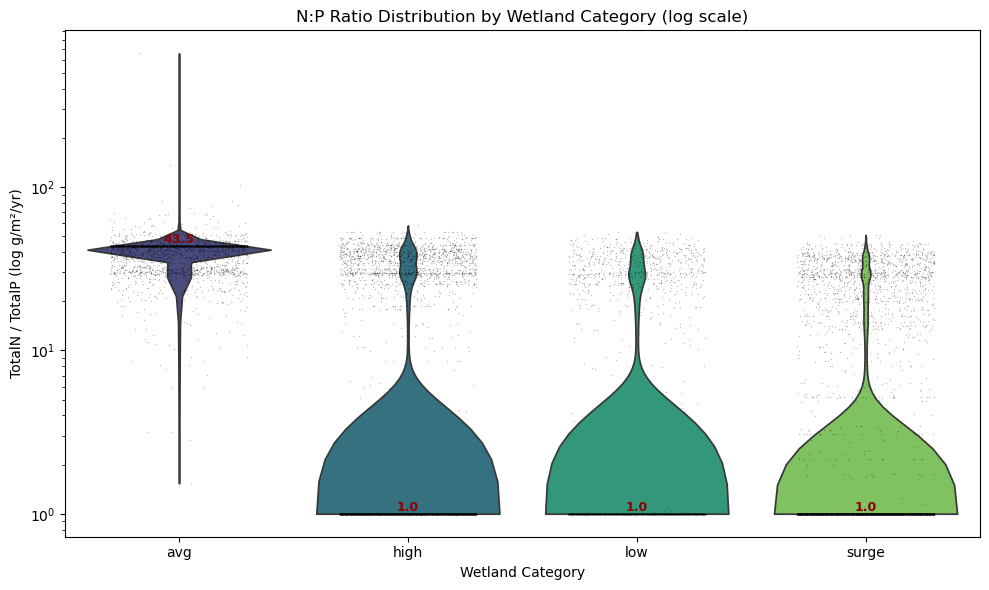

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# --- Build N:P ratio DataFrame ---
ratios = []
for category in categories:
    file = os.path.join(out_dir, f'Total_Direct_Indirect_Loads_{category}_{year}.csv')
    df = pd.read_csv(file)
    df['N_to_P_ratio'] = df[f'TotalN_{category}_grm2yr'] / df[f'TotalP_{category}_grm2yr']
    df['Category'] = category
    ratios.append(df[['N_to_P_ratio', 'Category']])

# --- Combine all categories ---
ratio_df = pd.concat(ratios, ignore_index=True)

# --- Initialize plot ---
plt.figure(figsize=(10, 6))

# Violin plot (distribution)
sns.violinplot(
    data=ratio_df, x='Category', y='N_to_P_ratio', hue='Category',
    palette='viridis', legend=False, cut=0, density_norm='width', inner=None
)

# Swarmplot (individual points)
sns.stripplot(
    data=ratio_df, x='Category', y='N_to_P_ratio',
    color='black', size=1, jitter=0.3, alpha=0.25
)

# Log scale
plt.yscale('log')
plt.ylabel('TotalN / TotalP (log g/m²/yr)')
plt.xlabel('Wetland Category')
plt.title('N:P Ratio Distribution by Wetland Category (log scale)')

# Annotate medians
medians = ratio_df.groupby("Category")["N_to_P_ratio"].median()
for i, cat in enumerate(medians.index):
    plt.text(i, medians[cat], f'{medians[cat]:.1f}',
             ha='center', va='bottom', fontweight='bold', fontsize=9, color='darkred')

# Layout and save
plt.tight_layout()
plt.savefig(os.path.join(out_dir_fig, f"N_to_P_Ratio_BoxViolin_{year}.png"), dpi=300)
plt.show()


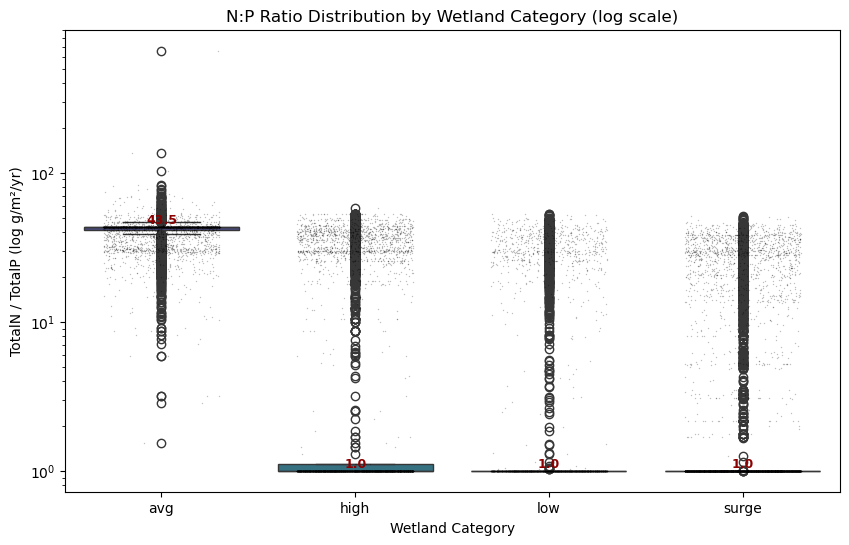

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# --- Build N:P ratio DataFrame ---
ratios = []
for category in categories:
    file = os.path.join(out_dir, f'Total_Direct_Indirect_Loads_{category}_{year}.csv')
    df = pd.read_csv(file)
    df['N_to_P_ratio'] = df[f'TotalN_{category}_grm2yr'] / df[f'TotalP_{category}_grm2yr']
    df['Category'] = category
    ratios.append(df[['N_to_P_ratio', 'Category']])

# --- Combine all categories ---
ratio_df = pd.concat(ratios, ignore_index=True)
ratio_df = ratio_df[ratio_df['N_to_P_ratio'] > 0]  # Avoid log errors

# --- Initialize plot ---
plt.figure(figsize=(10, 6))

# Boxplot (replacing violin plot)
sns.boxplot(
    data=ratio_df, x='Category', y='N_to_P_ratio',
    hue='Category', palette='viridis', legend=False
)

# Optional: Swarmplot for individual points
sns.stripplot(
    data=ratio_df, x='Category', y='N_to_P_ratio',
    color='black', size=1, jitter=0.3, alpha=0.25
)

# Log scale
plt.yscale('log')
plt.ylabel('TotalN / TotalP (log g/m²/yr)')
plt.xlabel('Wetland Category')
plt.title('N:P Ratio Distribution by Wetland Category (log scale)')

# Annotate medians
medians = ratio_df.groupby("Category")["N_to_P_ratio"].median()
for i, cat in enumerate(medians.index):
    plt.text(i, medians[cat], f'{medians[cat]:.1f}',
             ha='center', va='bottom', fontweight='bold', fontsize=9, color='darkred')


## Plot Direct loads

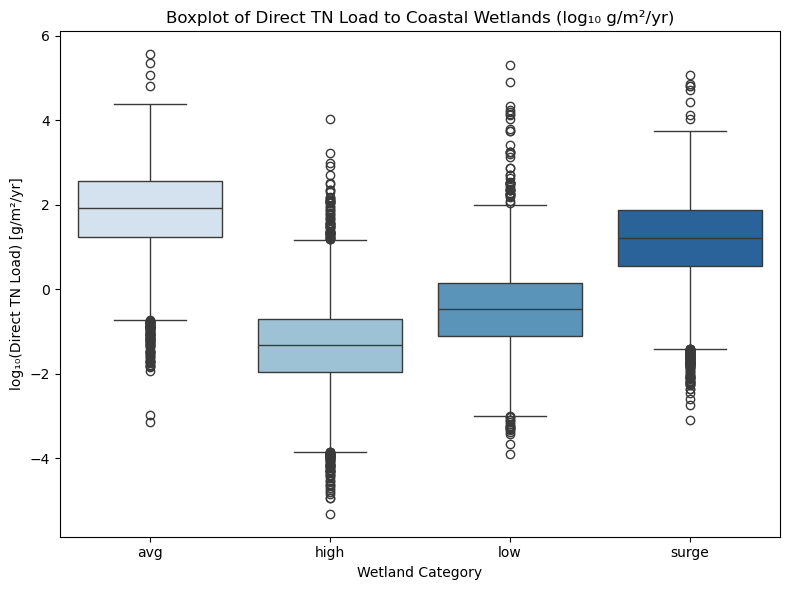

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Define categories and year
categories = ["avg", "high", "low", "surge"]
year = 23
long_data = []

# Build long-format DataFrame using Direct TN
for cat in categories:
    df = globals()[f"Total_{cat}_{year}"]
    tn_col = f"CoastalWatershedDirectTN_{cat}_grm2yr"
    
    subset = pd.DataFrame({
        "Category": cat,
        "DirectTN": df[tn_col]
    })
    long_data.append(subset)

# Combine and log-transform
long_df = pd.concat(long_data, ignore_index=True)
long_df = long_df[long_df['DirectTN'] > 0]
long_df['log10_DirectTN'] = np.log10(long_df['DirectTN'])

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=long_df,
    x="Category",
    y="log10_DirectTN",
    hue="Category",      # Fixes the warning
    palette="Blues",
    legend=False         # Prevents duplicate legend
)
plt.title("Boxplot of Direct TN Load to Coastal Wetlands (log₁₀ g/m²/yr)")
plt.ylabel("log₁₀(Direct TN Load) [g/m²/yr]")
plt.xlabel("Wetland Category")
plt.tight_layout()
plt.savefig(os.path.join(out_dir_fig, f"Boxplot_DirectTN_log10_{year}.png"), dpi=300)
plt.show()


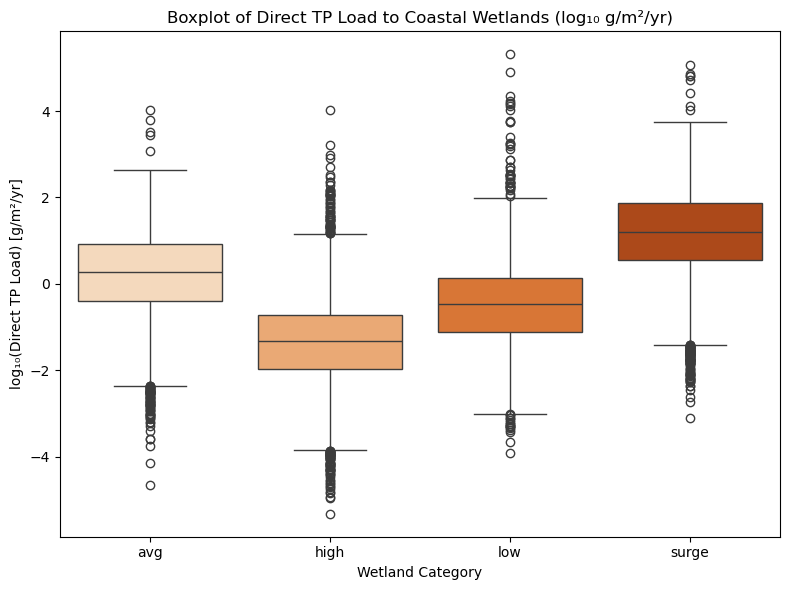

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Define categories and year
categories = ["avg", "high", "low", "surge"]
year = 23
long_data_tp = []

# Build long-format DataFrame using Direct TP
for cat in categories:
    df = globals()[f"Total_{cat}_{year}"]
    tp_col = f"CoastalWatershedDirectTP_{cat}_grm2yr"
    
    subset = pd.DataFrame({
        "Category": cat,
        "DirectTP": df[tp_col]
    })
    long_data_tp.append(subset)

# Combine and log-transform
long_df_tp = pd.concat(long_data_tp, ignore_index=True)
long_df_tp = long_df_tp[long_df_tp['DirectTP'] > 0]
long_df_tp['log10_DirectTP'] = np.log10(long_df_tp['DirectTP'])

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=long_df_tp,
    x="Category",
    y="log10_DirectTP",
    hue="Category",      # Fixes the FutureWarning
    palette="Oranges",
    legend=False         # Avoid duplicate legend
)
plt.title("Boxplot of Direct TP Load to Coastal Wetlands (log₁₀ g/m²/yr)")
plt.ylabel("log₁₀(Direct TP Load) [g/m²/yr]")
plt.xlabel("Wetland Category")
plt.tight_layout()
plt.savefig(os.path.join(out_dir_fig, f"Boxplot_DirectTP_log10_{year}.png"), dpi=300)
plt.show()


## plot to compare differnt inundatios

In [11]:
import pandas as pd

# Create list of categories and year
categories = ["avg", "high", "low", "surge"]
year = 23

# Collect data
long_data = []

for cat in categories:
    df_name = f"Total_{cat}_{year}"
    df = globals()[df_name]
    
    # Extract TN and TP values and attach category label
    tn_col = f"TotalN_{cat}_grm2yr"
    tp_col = f"TotalP_{cat}_grm2yr"
    
    subset = pd.DataFrame({
        "Category": cat,
        "TotalN": df[tn_col],
        "TotalP": df[tp_col]
    })
    
    long_data.append(subset)

# Concatenate into long_df
long_df = pd.concat(long_data, ignore_index=True)


In [15]:
Total_avg_23.columns

Index(['CW_Id', 'CoastalWatershedDirectTN_avg_grm2yr',
       'CoastalWatershedDirectTP_avg_grm2yr', 'TotalIndirectCW_TN_grm2yr',
       'TotalIndirectCW_TP_grm2yr', 'TotalN_avg_grm2yr', 'TotalP_avg_grm2yr',
       'Wetland', 'group_ids', 'Category'],
      dtype='object')

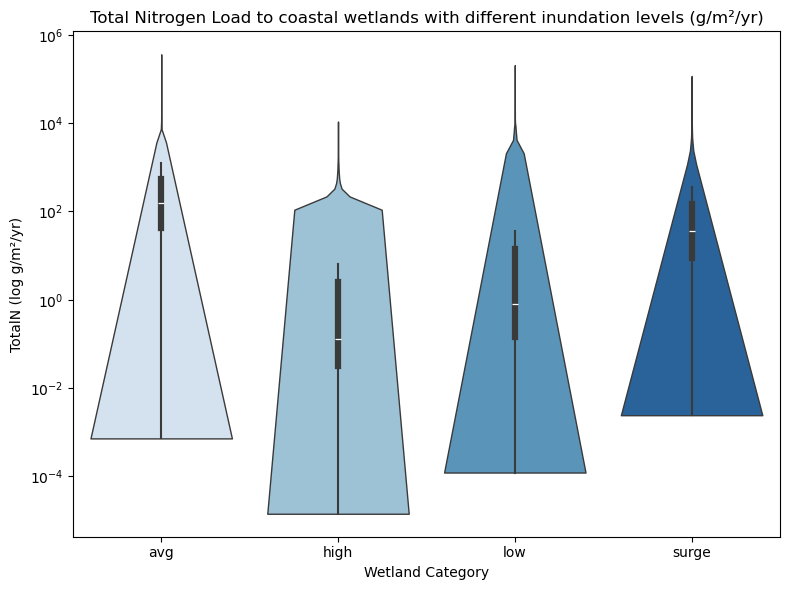

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Filter non-positive values to avoid log errors
long_df = long_df[long_df['TotalN'] > 0]

plt.figure(figsize=(8, 6))
sns.violinplot(
    data=long_df,
    x="Category",
    y="TotalN",
    hue="Category",         # Set hue to match x
    palette="Blues",
    cut=0,
    linewidth=1,
    inner="box",
    legend=False            # Suppress duplicate legend
)
plt.yscale("log")
plt.title("Total Nitrogen Load to coastal wetlands with different inundation levels (g/m²/yr)")
plt.ylabel("TotalN (log g/m²/yr)")
plt.xlabel("Wetland Category")
plt.tight_layout()
plt.savefig(os.path.join(out_dir_fig, f"TotalN_violinplot_categorycomparison_{year}.png"), dpi=300)
plt.show()


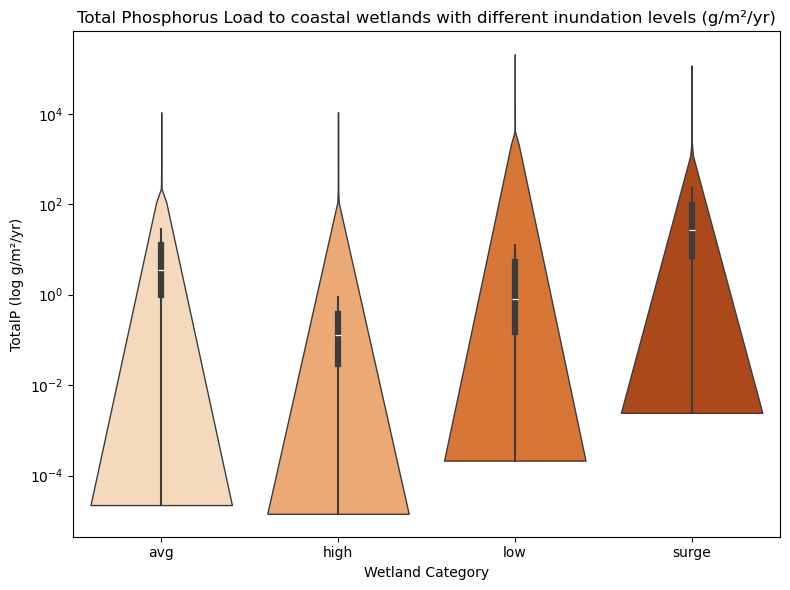

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Filter non-positive values to avoid log errors
long_df = long_df[long_df['TotalP'] > 0]

plt.figure(figsize=(8, 6))
sns.violinplot(
    data=long_df,
    x="Category",
    y="TotalP",
    hue="Category",         # Set hue to match x
    palette="Oranges",
    cut=0,
    linewidth=1,
    inner="box",
    legend=False            # Suppress duplicate legend
)
plt.yscale("log")
plt.title("Total Phosphorus Load to coastal wetlands with different inundation levels (g/m²/yr)")
plt.ylabel("TotalP (log g/m²/yr)")
plt.xlabel("Wetland Category")
plt.tight_layout()
plt.savefig(os.path.join(out_dir_fig, f"TotalP_violinplot_categorycomparison_{year}.png"), dpi=300)
plt.show()


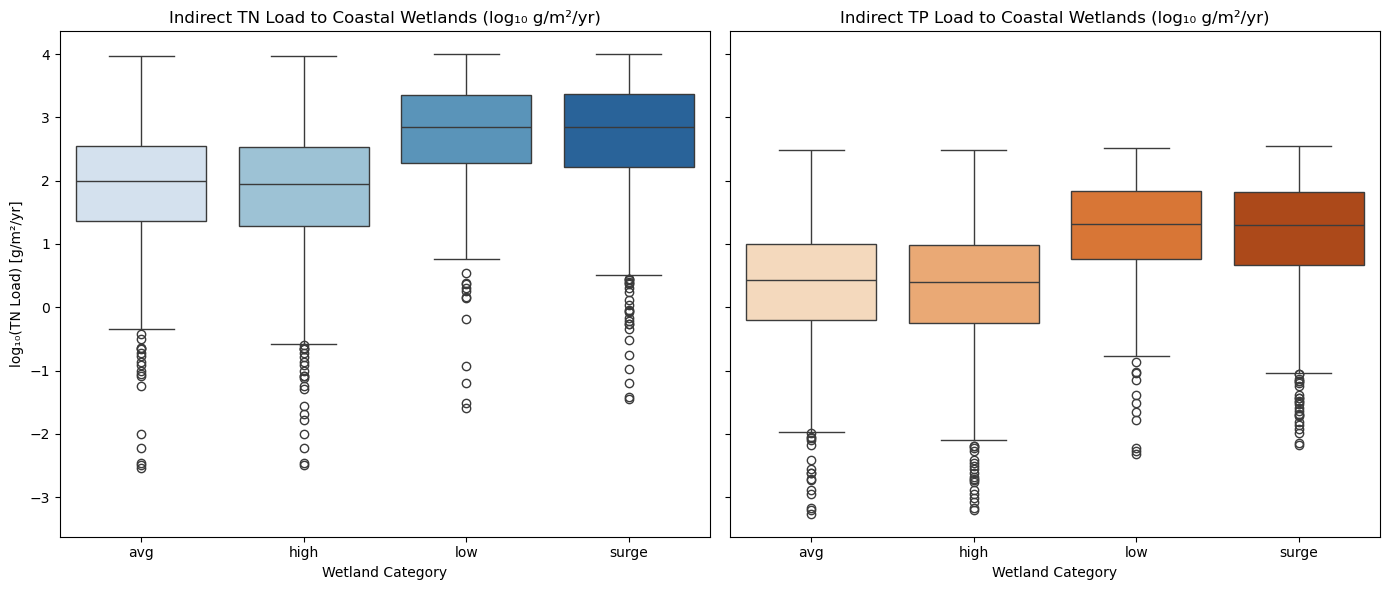

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Categories and year
categories = ["avg", "high", "low", "surge"]
year = 23

# ---- INDIRECT TN ----
long_data_tn = []
for cat in categories:
    df = globals()[f"Total_{cat}_{year}"]
    tn_col = "TotalIndirectCW_TN_grm2yr"
    subset = pd.DataFrame({
        "Category": cat,
        "IndirectTN": df[tn_col]
    })
    long_data_tn.append(subset)

long_df_tn = pd.concat(long_data_tn, ignore_index=True)
long_df_tn = long_df_tn[long_df_tn['IndirectTN'] > 0]
long_df_tn['log10_IndirectTN'] = np.log10(long_df_tn['IndirectTN'])

# ---- INDIRECT TP ----
long_data_tp = []
for cat in categories:
    df = globals()[f"Total_{cat}_{year}"]
    tp_col = "TotalIndirectCW_TP_grm2yr"
    subset = pd.DataFrame({
        "Category": cat,
        "IndirectTP": df[tp_col]
    })
    long_data_tp.append(subset)

long_df_tp = pd.concat(long_data_tp, ignore_index=True)
long_df_tp = long_df_tp[long_df_tp['IndirectTP'] > 0]
long_df_tp['log10_IndirectTP'] = np.log10(long_df_tp['IndirectTP'])

# ---- PLOTTING ----
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Boxplot for TN
sns.boxplot(
    data=long_df_tn,
    x="Category",
    y="log10_IndirectTN",
    hue="Category",
    palette="Blues",
    legend=False,
    ax=axs[0]
)
axs[0].set_title("Indirect TN Load to Coastal Wetlands (log₁₀ g/m²/yr)")
axs[0].set_ylabel("log₁₀(TN Load) [g/m²/yr]")
axs[0].set_xlabel("Wetland Category")

# Boxplot for TP
sns.boxplot(
    data=long_df_tp,
    x="Category",
    y="log10_IndirectTP",
    hue="Category",
    palette="Oranges",
    legend=False,
    ax=axs[1]
)
axs[1].set_title("Indirect TP Load to Coastal Wetlands (log₁₀ g/m²/yr)")
axs[1].set_ylabel("")  # Empty for cleaner layout
axs[1].set_xlabel("Wetland Category")

plt.tight_layout()
plt.savefig(os.path.join(out_dir_fig, f"Boxplot_IndirectTN_TP_log10_{year}.png"), dpi=300)
plt.show()
